---
## Import packages

In [3]:
# !pip install farasapy
# !pip install Tashaphyne==0.3.4.1
# !pip install wordcloud
# !pip install ar_wordcloud
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# !pip install art

In [4]:
from art import*
art= text2art ("Let 's     Go    !!!")
print(art)

 _            _     _             ____             _  _  _ 
| |      ___ | |_  ( ) ___       / ___|  ___      | || || |
| |     / _ \| __| |/ / __|     | |  _  / _ \     | || || |
| |___ |  __/| |_     \__ \     | |_| || (_) |    |_||_||_|
|_____| \___| \__|    |___/      \____| \___/     (_)(_)(_)
                                                           



In [5]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Gensim
import gensim, spacy, logging
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

import string
import time
import unicodedata as ud
import arabic_reshaper
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.decomposition import LatentDirichletAllocation


from ar_wordcloud import ArabicWordCloud

In [26]:
import pyarabic.araby as araby
import pyarabic.number as number

In [6]:
from tashaphyne.stemming import ArabicLightStemmer

In [7]:
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer

In [8]:
from farasa.pos import FarasaPOSTagger
from farasa.ner import FarasaNamedEntityRecognizer
from farasa.diacratizer import FarasaDiacritizer
from farasa.segmenter import FarasaSegmenter
from farasa.stemmer import FarasaStemmer

## Read and exploring the data

In [9]:
df = pd.read_csv('/content/SaudiNews3k')
df.drop(columns= ['Unnamed: 0'], inplace= True)
df

,source,title,content
0,aljazirah,مدرب الأهلي يستبعد لاعبين جديدين من قائمته قبل...,جروس\nعلمت (الجزيرة) أن مدرب الأهلي كريستيان ...
1,alriyadh,تقرير: تراجع الإيرادات المباشرة لشركات الاتصال...,تراجع إجمالي الإيرادات المباشرة لشركات الا...
2,aleqtisadiya,أوباما يدعو بريطانيا للبقاء في الاتحاد الأوروبي,حث الرئيس الأمريكي باراك أوباما بريطانيا على ...
3,sabq,الغذامي يقتحم عالم الصحافة الإلكترونية بمقال أ...,عاصم الغامدي - سبق – جدة: انضم الكاتب والناقد...
4,aawsat,«إف بي آي»: توقيف رجل يقدم نفسه على «فيسبوك» ب...,أعلن مكتب التحقيقات الفدرالي (اف بي آي) مساء أ...
...,...,...,...
2995,alriyadh,الصحة: ثلاث إصابات بكورونا وشفاء حالة في الرياض,أعلنت وزارة الصحة اليوم الجمعة عن تسجيل ثل...
2996,alriyadh,السيسي: مصر والسعودية هما جناحا الأمن القومي ا...,بحضور فخامة الرئيس عبدالفتاح السيسي رئيس ج...
2997,aljazirah,تعليم القصيم يستقبل سفيرات الحزم,\nاستقبلت الإدارة العامة للتعليم بمنطقة القصيم...
2998,okaz,ركن السيارة.. مظهر حضاري غائب,المشهد المتصدر اليوم في الطرقات لدينا هو المط...


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   source   3000 non-null   object
 1   title    2995 non-null   object
 2   content  2988 non-null   object
dtypes: object(3)
memory usage: 70.4+ KB


In [11]:
df.duplicated().sum()

22

In [12]:
df.drop_duplicates(inplace = True)

In [51]:
# To display full text
pd.set_option('display.max_colwidth',-1)#can see the whole data on one single row
# complaints_df
df

source  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

## NLP Preprocessing

In [13]:
max(df.content.str.len())

21130.0

In [14]:
min(df.content.str.len())

1.0

**removing observtions less than 120**

In [15]:
df = df[df.content.str.len() > 120]

In [16]:
df.shape

(2918, 3)

In [17]:
df.content.isna().sum()

0

### **Removing Non-arabic letters, numbers, amiss typo and special characters**


In [18]:
# function to clean and normalize text 
def clean_text(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']  
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
        
    text = text.strip()
    
    return text

In [19]:
arabic_punctuations = '''«»`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)


def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    
    return text


def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text


def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [20]:
# clean and normalize text
df.content  = df.content.apply(lambda x: clean_text(x))

# remove punctuation
df.content  = df.content.apply(lambda x: remove_punctuations(x))

# remove diacritics
df.content  = df.content.apply(lambda x: remove_diacritics(x))

# remove repeating char
df.content  = df.content.apply(lambda x: remove_repeating_char(x))

# remove english letters
df.content = df.content.apply(lambda x: re.sub(r'[a-zA-Z]', '', x))

# remove a special character 
df.content = df.content.apply(lambda x: re.sub(r'[_]+', '', x))

# remove english numbers
df.content = df.content.apply(lambda x: re.sub(r'/[0-9\u0621-\u064A]+/u', '', x))

# remove space
df.content  = df.content.str.replace('\d+', '')

In [22]:
# Convert to list
data = df[df.columns[2]].values.tolist()

### **Stemming**

In [48]:
stopـwords =nltk.corpus.stopwords.words("arabic")
stopـwords.extend(['هـ', 'د', 'م', 'الى', 'ان', 'اذ', 'لهذه',
                   'قال', 'وقال', 'اكد', 'عدد', 'بعدد', 'وعدد'
                   , 'والتي', 'بن', 'بنت', 'وقد', 'ا', 'عبر',
                   'خلال', 'او', 'الا', 'وان', 'اي', 'بان', 'كان'
                   , 'كانت' ,'تم','الف','مليون', 'وفي', 'وقد','اكثر','اقل'
                   , 'انه','وانه', 'قالت', 'وقالت', 'وتم','اذا', 'وسوف', 'ه', 'م', 'كثير',
                   'ودليل', 'معهم','مصدر'
                   ,'مر','على','تنتهي','كبيرة','تستمر','الفرج','وواضح','وصاحب',
                   'يتم','،وذلك','تكون','عليها'
                   ,'انها','امس','العامه','الثاني','لاداره','اكبر','الف','اليوم'
                   ,'خلال','الاسبوع','اباغسطس','اباطيلهم','ابارك','ابارا','ابار','اباده','اباحيا','اباتشي',
                   'ابابا','ابائهم','ابائه','اباؤهم','اباؤنا','اباؤكن','اباءهم','اباءنا','اباء','ابا'
                   ,'اب','ائمه','ائذن','ائتماني','ائتلافيه','ائتلافا','ئايه','اباحه','ابالخيل'
                   ,'ابالغ','ابان','ابانات','ابانها','اباه','اباوت',
                   'ابت','ابتد','ابتدا','ابتداء','ابتدائي',
                   'ابتدائيا','ابتدائيه','ابتدات','ابتدعها','ابتدعوا','ابتسام','ابتسامات','ابتسامتكم',
                   'ابتسامتها','ابتسامتهم','ابتسامه'
                   ,'ابتسم','ابتسمت'
                   ,'ابتعاثاهل','ابتعاثهم'
                   ,'ﺍﻟﻔﻴﻮﺵ','ﺍﻟﻤﺨﺘﻠﻔﺔ','ﺍﻟﻤﻨﺎﻃﻖ','ﺍﻟﻤﻄﺎﺭ','ﺍﻟﻤﻌﻨﻴﺔ','ﺑﺎﺏ','ﺑﻤﺮﻳﺲ',
                   'ﺣﺎﻟﻴﺎ','ﺣﺘﻰ','ﺩﺍﺭ','ﺳﺘﻮﺍﺻﻞ','ﻋﻤﻠﻴﺎﺗﻬﺎ'
                   ,'ﻓﻲ','ﻛﻞ','ﻟﻌﻮﺩﺓ','ﻣنطقه','ﻣﺠﺎﻝ','ﻣﻊ','ﻣﻦ','ﻭان','ﻭﺍﺳﺘﻘﺒﺎﻝ'
                   ,'ﻭﺍﻟﻜﺜﻴﺮ','ﻷي','ﻹكمال','ﻹنشائه','ﻭﻣﻌﺎﺭﻙ','ﻭﻣﺴﺘﻘﺮﺓ','ﻭﺍﻟﻤﻮﺍﻧﺊ','ﺇﻟﻰ'])

In [32]:
#stemming as experiment
def apply_stemming_and_Stopwords(texts):
    st = ISRIStemmer()
    return [[st.stem(word) for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

In [34]:
stemmstop_word=apply_stemming_and_Stopwords(df.content)

### **TF-IDF Vectorizer**

In [49]:
# the document-term matrix 
tfidf = TfidfVectorizer(stop_words=stopـwords)
doc_words = tfidf.fit_transform(df.content)
pd.DataFrame(doc_words.toarray(),columns=tfidf.get_feature_names())

,اؤدي,اؤكد,اؤمن,ائتلاف,ائتمان,ائتمانيه,اباحي,اباد,ابتدعوه,ابتذال,ابتزاز,ابتعاث,ابتعاد,ابتعاده,ابتعادهم,ابتعث,ابتعثت,ابتعد,ابتعدت,ابتعدوا,ابتغاء,ابتغي,ابتكار,ابتكارا,ابتكارات,ابتكاره,ابتكر,ابتكرها,ابتكروا,ابتلاء,ابتلاع,ابتلعت,ابتلي,ابتليت,ابتهاجا,ابتهالا,ابتياع,ابجديات,ابجديتي,ابحاث,...,يونيسيف,يونيكر,يونيكريدت,يونيه,يونيوحزيران,يونيور,يونيون,يوهان,يوهاندري,يوهانس,يوهمون,يوهندي,يوي,يويشي,يويفا,يويو,یشرف,یعني,یلقبه,ﺁﻣﻨﺔ,ﺇﻟﻰ,ﺍﺳﺘﻬﺪﻑ,ﺍﻟﺤﻮﺛﻲ,ﺍﻟﺤﻴﺎﺓ,ﺍﻟﺸﻌﺒﻴﺔ,ﺍﻟﺼﺪﺭﻳﻦ,ﺍﻟﻌﺎﻣﺔ,ﺍﻟﻌﺴﻜﺮﻳﺔ,ﺍﻟﻘﺎﺿﻲ,ﺍﻟﻤﺘﻤﺮﺩﻳﻦ,ﺍﻟﻤﻘﺎﻭﻣﺔ,ﺍﻟﻴﺎﻓﻌﻲ,ﺍﻟﻼﺯﻣﺔ,ﺍﻹﻏﺎﺛﺔ,ﻋﻨﻴﻔﺔ,ﻏﺎﺭﺍﺕ,ﻓﺮﺕ,ﻟﻠﺘﺤﺎﻟﻒ,ﻣﺤﺮﺭﺓ,ﻣﺴﺎﻋﺪﺍﺕ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## EDA

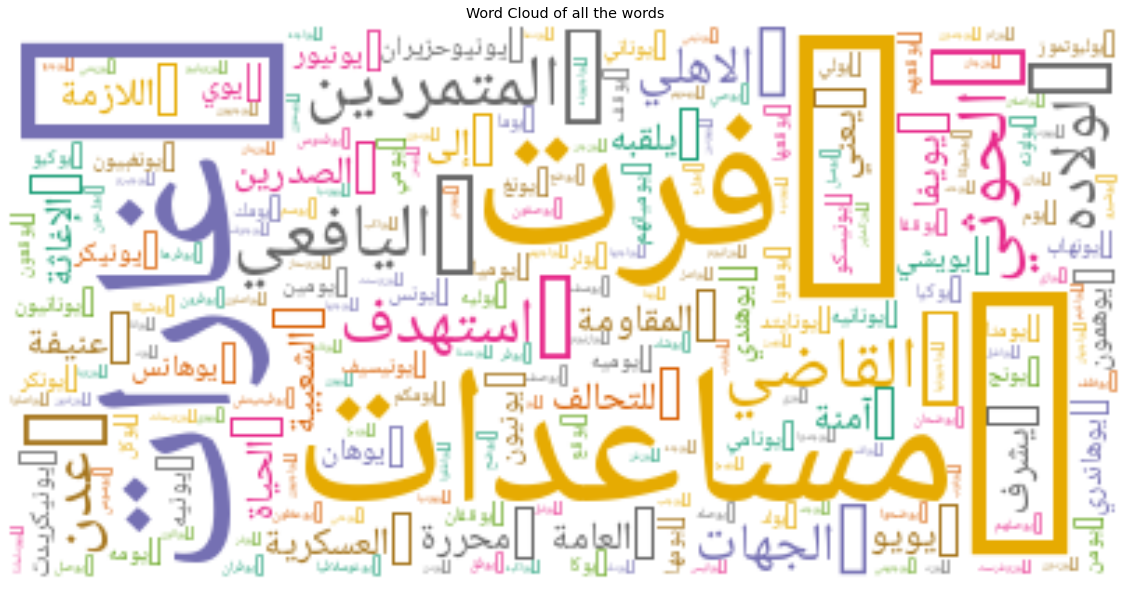

In [54]:
# print WordCloud visualization

awc = ArabicWordCloud(background_color="white");

mpl.rcParams['figure.figsize']=(20,12.0)  ;
mpl.rcParams['font.size']=12
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 

wordcloud = awc.generate(str(tfidf.get_feature_names())).from_text(str(tfidf.get_feature_names()));

print(wordcloud);
fig = plt.figure(1);
plt.imshow(wordcloud.recolor(colormap='Dark2'),interpolation='bilinear');
plt.title("Word Cloud of all the words");
plt.axis('off');

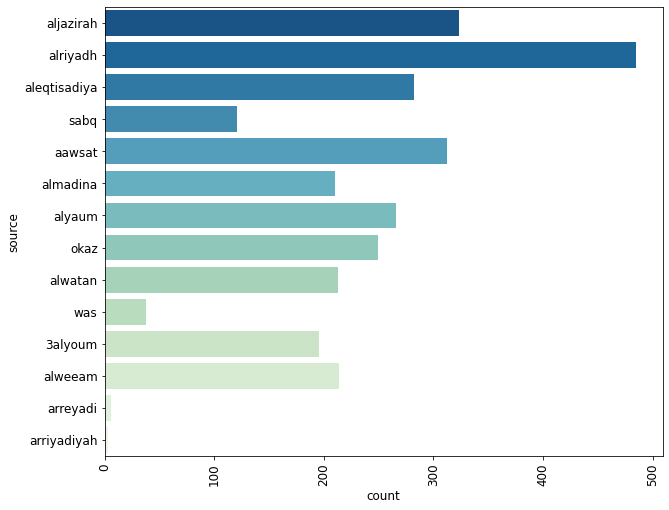

In [55]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.countplot(y="source", data=df, palette='GnBu_r');

source Distribution

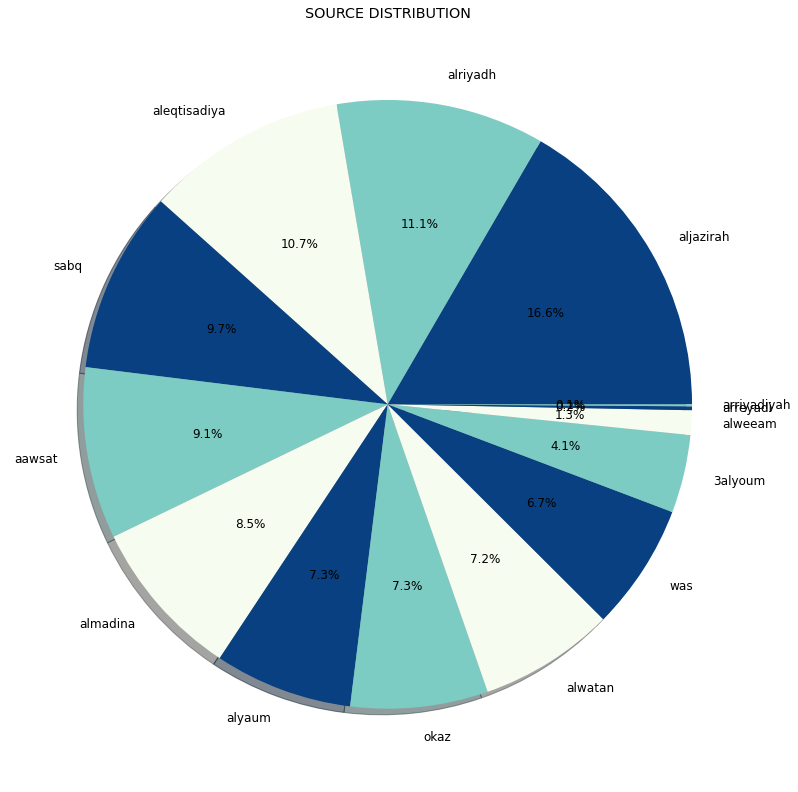

In [56]:
targetCounts = df['source'].value_counts()
targetLabels  = df['source'].unique()
# Make square figures and axes
plt.figure(1, figsize=(30,30))
the_grid = GridSpec(2, 2)

#Blues_r #PuBuGn #Sequential
cmap = plt.get_cmap('GnBu_r')
colors = [cmap(i) for i in np.linspace(0, 1, 3)]
plt.subplot(the_grid[0, 1], aspect=1, title='SOURCE DISTRIBUTION')

source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors)

## **Topic Modeling**


1. NMF

In [57]:
# function to display topics with words
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
#         else:
#             print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    

def display_top(model, feature_names, no_top_words, topic_names=None):
    
    my_dict = {'topic_0':'','topic_1':'','topic_2':'','topic_3':'','topic_4':''}
    ctr = 0
    for ix, topic in enumerate(model.components_):
                #if not topic_names or not topic_names[ix]:
#             print("\nTopic ", ix)
        txt = ",".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        my_dict['topic_'+str(ctr)] = txt
        ctr+=1
#         print('words are::: ',txt)
    return my_dict

In [58]:
topic_nums = list(np.arange(3, 10, 1))

#nmf_models = []
for num in topic_nums:
    nmf = NMF(num)
    #nmf_models.append(nmf)
    nmf.fit_transform(doc_words)
    display_topics(nmf, tfidf.get_feature_names(), 50)
    print("------------------------------------------")


Topic  0
علي, الي, ايران, العام, داعش, النفط, العمل, السعوديه, المائه, عام, المتحده, عدن, عد, الملكه, حتي, المنطقه, الماضي, الاتفاق, اسعار, مليار, وزاره, بنسبه, مدينه, المقاومه, المدينه, اخري, بشكل, منطقه, محافظه, شركه, السوق, تنظيم, البلديه, النظام, الحكومه, اليمن, الرئيس, الطاقه, العالم, وهي, وذلك, ضد, الشركه, الدولي, ايضا, الولايات, فان, الايراني, دول, احد

Topic  1
عبدالعزيز, الامير, اله, السمو, ولي, الملكي, الحرمين, الشريفين, خادم, سلمان, محمد, الملك, سعود, وزير, صاحب, العهد, عسير, الملكه, سموه, نائب, عبداله, ال, رئيس, فيصل, مجلس, الدكتور, خالد, منطقه, الوزراء, العربيه, نايف, الامن, الطوارئ, علي, امير, الدفاع, السعوديه, جمهوريه, الفيصل, الشهداء, الوطن, مكه, المكرمه, بمنطقه, فهد, مدير, سمو, جده, حفظه, الخاصه

Topic  2
الفريق, الاتحاد, النادي, علي, الاعب, الموسم, الاعبين, القدم, المدرب, نادي, السعودي, لكره, لاعب, فريق, الهلال, المعسكر, الي, المقبل, النصر, السوبر, الفني, كاس, الاهلي, اداره, المباراه, الاول, الاداره, الدوري, الانديه, امام, مباراه, الوديه, لفريق, مدرب, الشباب, سان, لا

In [61]:
nmf_model = NMF(8)
doc_topic = nmf_model.fit_transform(doc_words)

In [63]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"
             ,"component_6","component_7","component_8"],
             columns = tfidf.get_feature_names())
topic_word

,اؤدي,اؤكد,اؤمن,ائتلاف,ائتمان,ائتمانيه,اباحي,اباد,ابتدعوه,ابتذال,ابتزاز,ابتعاث,ابتعاد,ابتعاده,ابتعادهم,ابتعث,ابتعثت,ابتعد,ابتعدت,ابتعدوا,ابتغاء,ابتغي,ابتكار,ابتكارا,ابتكارات,ابتكاره,ابتكر,ابتكرها,ابتكروا,ابتلاء,ابتلاع,ابتلعت,ابتلي,ابتليت,ابتهاجا,ابتهالا,ابتياع,ابجديات,ابجديتي,ابحاث,...,يونيسيف,يونيكر,يونيكريدت,يونيه,يونيوحزيران,يونيور,يونيون,يوهان,يوهاندري,يوهانس,يوهمون,يوهندي,يوي,يويشي,يويفا,يويو,یشرف,یعني,یلقبه,ﺁﻣﻨﺔ,ﺇﻟﻰ,ﺍﺳﺘﻬﺪﻑ,ﺍﻟﺤﻮﺛﻲ,ﺍﻟﺤﻴﺎﺓ,ﺍﻟﺸﻌﺒﻴﺔ,ﺍﻟﺼﺪﺭﻳﻦ,ﺍﻟﻌﺎﻣﺔ,ﺍﻟﻌﺴﻜﺮﻳﺔ,ﺍﻟﻘﺎﺿﻲ,ﺍﻟﻤﺘﻤﺮﺩﻳﻦ,ﺍﻟﻤﻘﺎﻭﻣﺔ,ﺍﻟﻴﺎﻓﻌﻲ,ﺍﻟﻼﺯﻣﺔ,ﺍﻹﻏﺎﺛﺔ,ﻋﻨﻴﻔﺔ,ﻏﺎﺭﺍﺕ,ﻓﺮﺕ,ﻟﻠﺘﺤﺎﻟﻒ,ﻣﺤﺮﺭﺓ,ﻣﺴﺎﻋﺪﺍﺕ
component_1,0.0,0.004,0.001,0.019,0.0,0.000,0.000,0.008,0.0,0.000,0.001,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.002,0.0,0.000,0.000,0.004,0.0,0.000,0.000,0.000,0.001,0.0,0.000,0.000,0.0,0.000,0.000,0.002,0.0,0.0,0.000,0.0,0.004,...,0.000,0.002,0.000,0.000,0.005,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.001,0.002,0.001,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_2,0.0,0.000,0.000,0.001,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.000,...,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.005,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_3,0.0,0.002,0.000,0.000,0.0,0.000,0.001,0.001,0.0,0.000,0.000,0.000,0.003,0.005,0.0,0.0,0.000,0.003,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.001,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.000,...,0.000,0.000,0.000,0.000,0.000,0.0,0.002,0.002,0.025,0.000,0.000,0.0,0.000,0.000,0.004,0.001,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_4,0.0,0.000,0.000,0.001,0.0,0.003,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.001,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.001,...,0.000,0.001,0.001,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_5,0.0,0.000,0.000,0.001,0.0,0.001,0.000,0.000,0.0,0.000,0.000,0.002,0.000,0.000,0.0,0.0,0.001,0.001,0.000,0.0,0.000,0.000,0.004,0.0,0.001,0.001,0.001,0.000,0.0,0.000,0.001,0.0,0.000,0.000,0.001,0.0,0.0,0.001,0.0,0.008,...,0.000,0.000,0.000,0.001,0.000,0.0,0.000,0.000,0.000,0.000,0.001,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_6,0.0,0.000,0.000,0.001,0.0,0.000,0.000,0.001,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.002,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.000,...,0.003,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.008,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.003,0.007,0.004,0.003,0.003,0.003,0.004,0.003,0.003,0.004,0.007,0.007,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003
component_7,0.0,0.000,0.000,0.000,0.0,0.000,0.002,0.004,0.0,0.001,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.001,0.001,0.0,0.001,0.001,0.000,0.0,0.000,0.000,0.000,0.001,0.0,0.001,0.000,0.0,0.002,0.002,0.000,0.0,0.0,0.000,0.0,0.000,...,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_8,0.0,0.002,0.000,0.000,0.0,0.003,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0

In [64]:
display_topics(nmf_model, tfidf.get_feature_names(), 50)



Topic  0
ايران, علي, داعش, الاتفاق, الي, النوي, تنظيم, المتحده, سوريا, الايراني, الخارجيه, تركيا, السوري, العراق, ضد, اوباما, الاسد, التركيه, النظام, الارهاب, السوريه, وزير, الولايات, حزب, التنظيم, كيري, المنطقه, دول, سوريه, الرئيس, الايرانيه, الجيش, واشنطن, مجلس, التركي, العراقيه, الدولي, العربيه, الامن, الكردستاني, الحكومه, الوزراء, التعاون, المعارضه, مصر, رئيس, الدول, العمال, الاميركي, القوات

Topic  1
الامير, عبدالعزيز, السمو, الملكي, ولي, الحرمين, الشريفين, خادم, سلمان, الملك, محمد, سعود, وزير, العهد, صاحب, الوزراء, رئيس, مجلس, فيصل, نائب, العربيه, الملكه, خالد, نايف, عبداله, ال, سموه, الدفاع, جمهوريه, الدكتور, الفيصل, امير, منطقه, السعوديه, مصر, تركي, النائب, لرئيس, البلدين, فهد, اله, مكه, ومعالي, سمو, جده, الرئيس, مساعد, الاستقبال, المكرمه, المركز

Topic  2
الفريق, الاتحاد, النادي, علي, الاعب, الموسم, الاعبين, القدم, المدرب, نادي, لكره, السعودي, لاعب, الي, فريق, المعسكر, الهلال, المقبل, النصر, السوبر, كاس, الفني, الاهلي, المباراه, الاول, الدوري, اداره, امام, الاداره, الانديه, م

2. LDA

In [65]:
# Define Search Param
search_params = {'n_components': [10, 9, 8, 7, 6, 5, 4, 3], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(doc_words)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 9, 8, 7, 6, 5, 4, 3]})

In [97]:
from sklearn.decomposition import LatentDirichletAllocation

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_words))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -82602.11364494462
Model Perplexity:  113086.61454496814


In [98]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(doc_words)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(10).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.040000,0.920000,0.040000,1
Doc1,0.030000,0.950000,0.030000,1
Doc2,0.030000,0.930000,0.030000,1
Doc3,0.050000,0.900000,0.050000,1
Doc4,0.030000,0.930000,0.030000,1
Doc5,0.030000,0.930000,0.030000,1
Doc6,0.040000,0.910000,0.040000,1
Doc7,0.040000,0.920000,0.040000,1
Doc8,0.030000,0.950000,0.030000,1
Doc9,0.020000,0.950000,0.020000,1


3. LSA

In [ ]:
## هنا نورة

**Topic modeling visualizton**

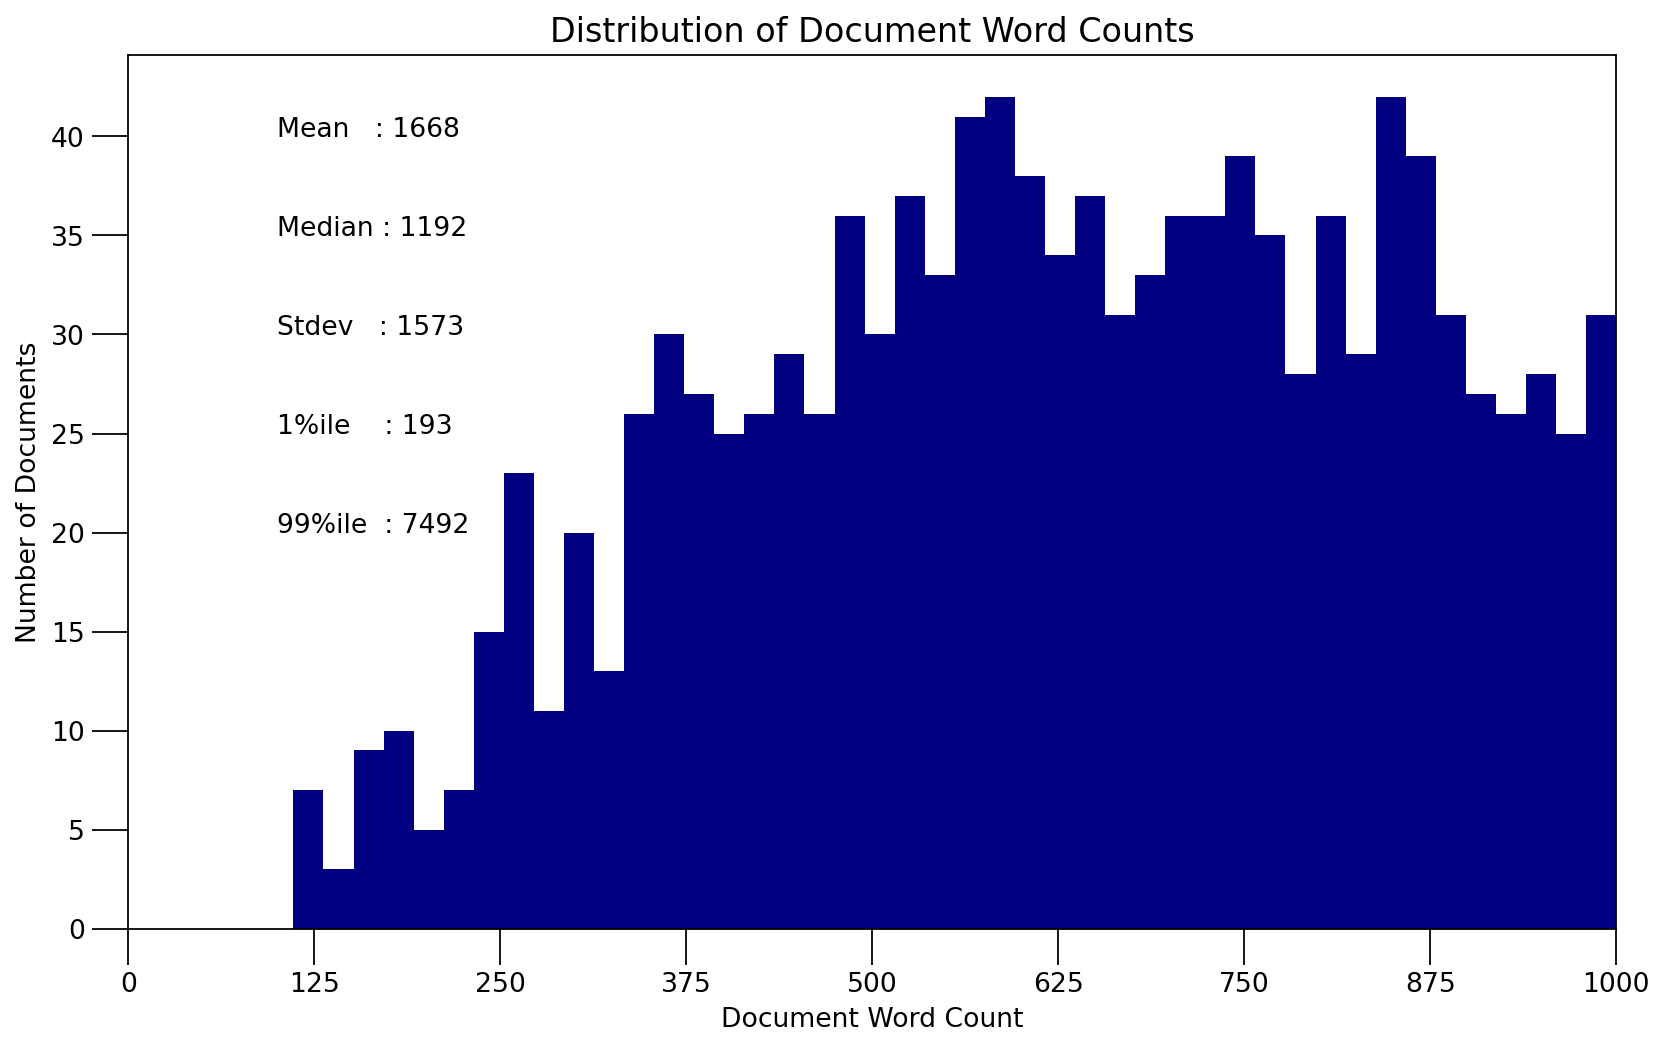

In [76]:
doc_lens = [len(d) for d in df.content]

# Plot
plt.figure(figsize=(12,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(100, 40, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(100,  35, "Median : " + str(round(np.median(doc_lens))))
plt.text(100,  30, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(100,  25, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(100,  20, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=15))

In [82]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)

# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['جروس', 'علمت', 'الجزيره', 'ان', 'مدرب', 'الاهلي', 'كريستيان', 'جروس', 'يستعد', 'لتقليص', 'قايمه', 'الفريق', 'مجدا', 'عقب', 'ختام', 'معسكر', 'الفريق', 'المقام', 'حاليا', 'في', 'مدينه', 'لوزان', 'السويسريه', 'والعوده', 'الي', 'جده', 'غدا', 'السبت', 'حيث', 'كشفت', 'المصادر', 'ان', 'القايمه', 'الاهلاويه', 'ستشهد', 'استبعاد', 'لاعبين', 'جديدين', 'من', 'بينهم', 'الظهير', 'الايسر', 'عبدالاله', 'بخاري', 'ليضاف', 'بذلك', 'الي', 'استغناء', 'جروس', 'عن', 'الخماسي', 'احمد', 'العوفي', 'وياسر', 'الفهمي', 'وسامر', 'سالم', 'ومحمد', 'مجرشي', 'وماجد', 'عسيري', 'قبل', 'معسكر', 'سويسرا', 'من', 'ناحيه', 'اخري', 'كسب', 'الفريق', 'اخر', 'ودياته', 'ضمن', 'معسكر', 'سويسرا', 'التي', 'خاضها', 'امام', 'لومنت', 'السويسري', 'وانتهت', 'اهلاويه', 'باربعه', 'اهداف', 'لهدف', 'سجلها', 'عمر', 'السومه', 'هدفين', 'واسلام', 'سراج', 'وليد', 'باخشوين']]


In [84]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stopـwords, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [88]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

print(lda_model.print_topics())

[(0, '0.009*"الخارجيه" + 0.007*"واوضح" + 0.006*"فريق" + 0.006*"الامنيه" + 0.005*"حق" + 0.005*"الجمعه" + 0.005*"عاما" + 0.005*"قوات" + 0.005*"الحركه" + 0.005*"قدره"'), (1, '0.010*"العام" + 0.010*"الرياض" + 0.008*"تنفيذ" + 0.008*"الماضي" + 0.007*"الالكترونيه" + 0.007*"الدفاع" + 0.006*"القضيه" + 0.005*"بنسبه" + 0.005*"المصريه" + 0.005*"التقرير"'), (2, '0.013*"الاعمال" + 0.010*"محمد" + 0.009*"يذكر" + 0.009*"اعمال" + 0.008*"حياه" + 0.008*"لجنه" + 0.007*"لبنان" + 0.007*"الرياضيه" + 0.006*"شركه" + 0.006*"التحالف"'), (3, '0.030*"حتي" + 0.011*"الامريكي" + 0.008*"وهي" + 0.007*"الحياه" + 0.006*"طريق" + 0.006*"سنوات" + 0.006*"الانسانيه" + 0.005*"النفط" + 0.005*"وذلك" + 0.005*"المشاعر"')]


In [89]:
# def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
#     # Init output
#     sent_topics_df = pd.DataFrame()

#     # Get main topic in each document
#     for i, row_list in enumerate(ldamodel[corpus]):
#         row = row_list[0] if ldamodel.per_word_topics else row_list            
#         # print(row)
#         row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         # Get the Dominant topic, Perc Contribution and Keywords for each document
#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j == 0:  # => dominant topic
#                 wp = ldamodel.show_topic(topic_num)
#                 topic_keywords = ", ".join([word for word, prop in wp])
#                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
#             else:
#                 break
#     sent_topics_df.columns = ['Dominant_Topic']

#     # Add original text to the end of the output
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
#     return(sent_topics_df)


# df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# # Format
# df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# df_dominant_topic.head(10)

ValueError: ignored

In [96]:
sent_topics_df.shape

NameError: ignored

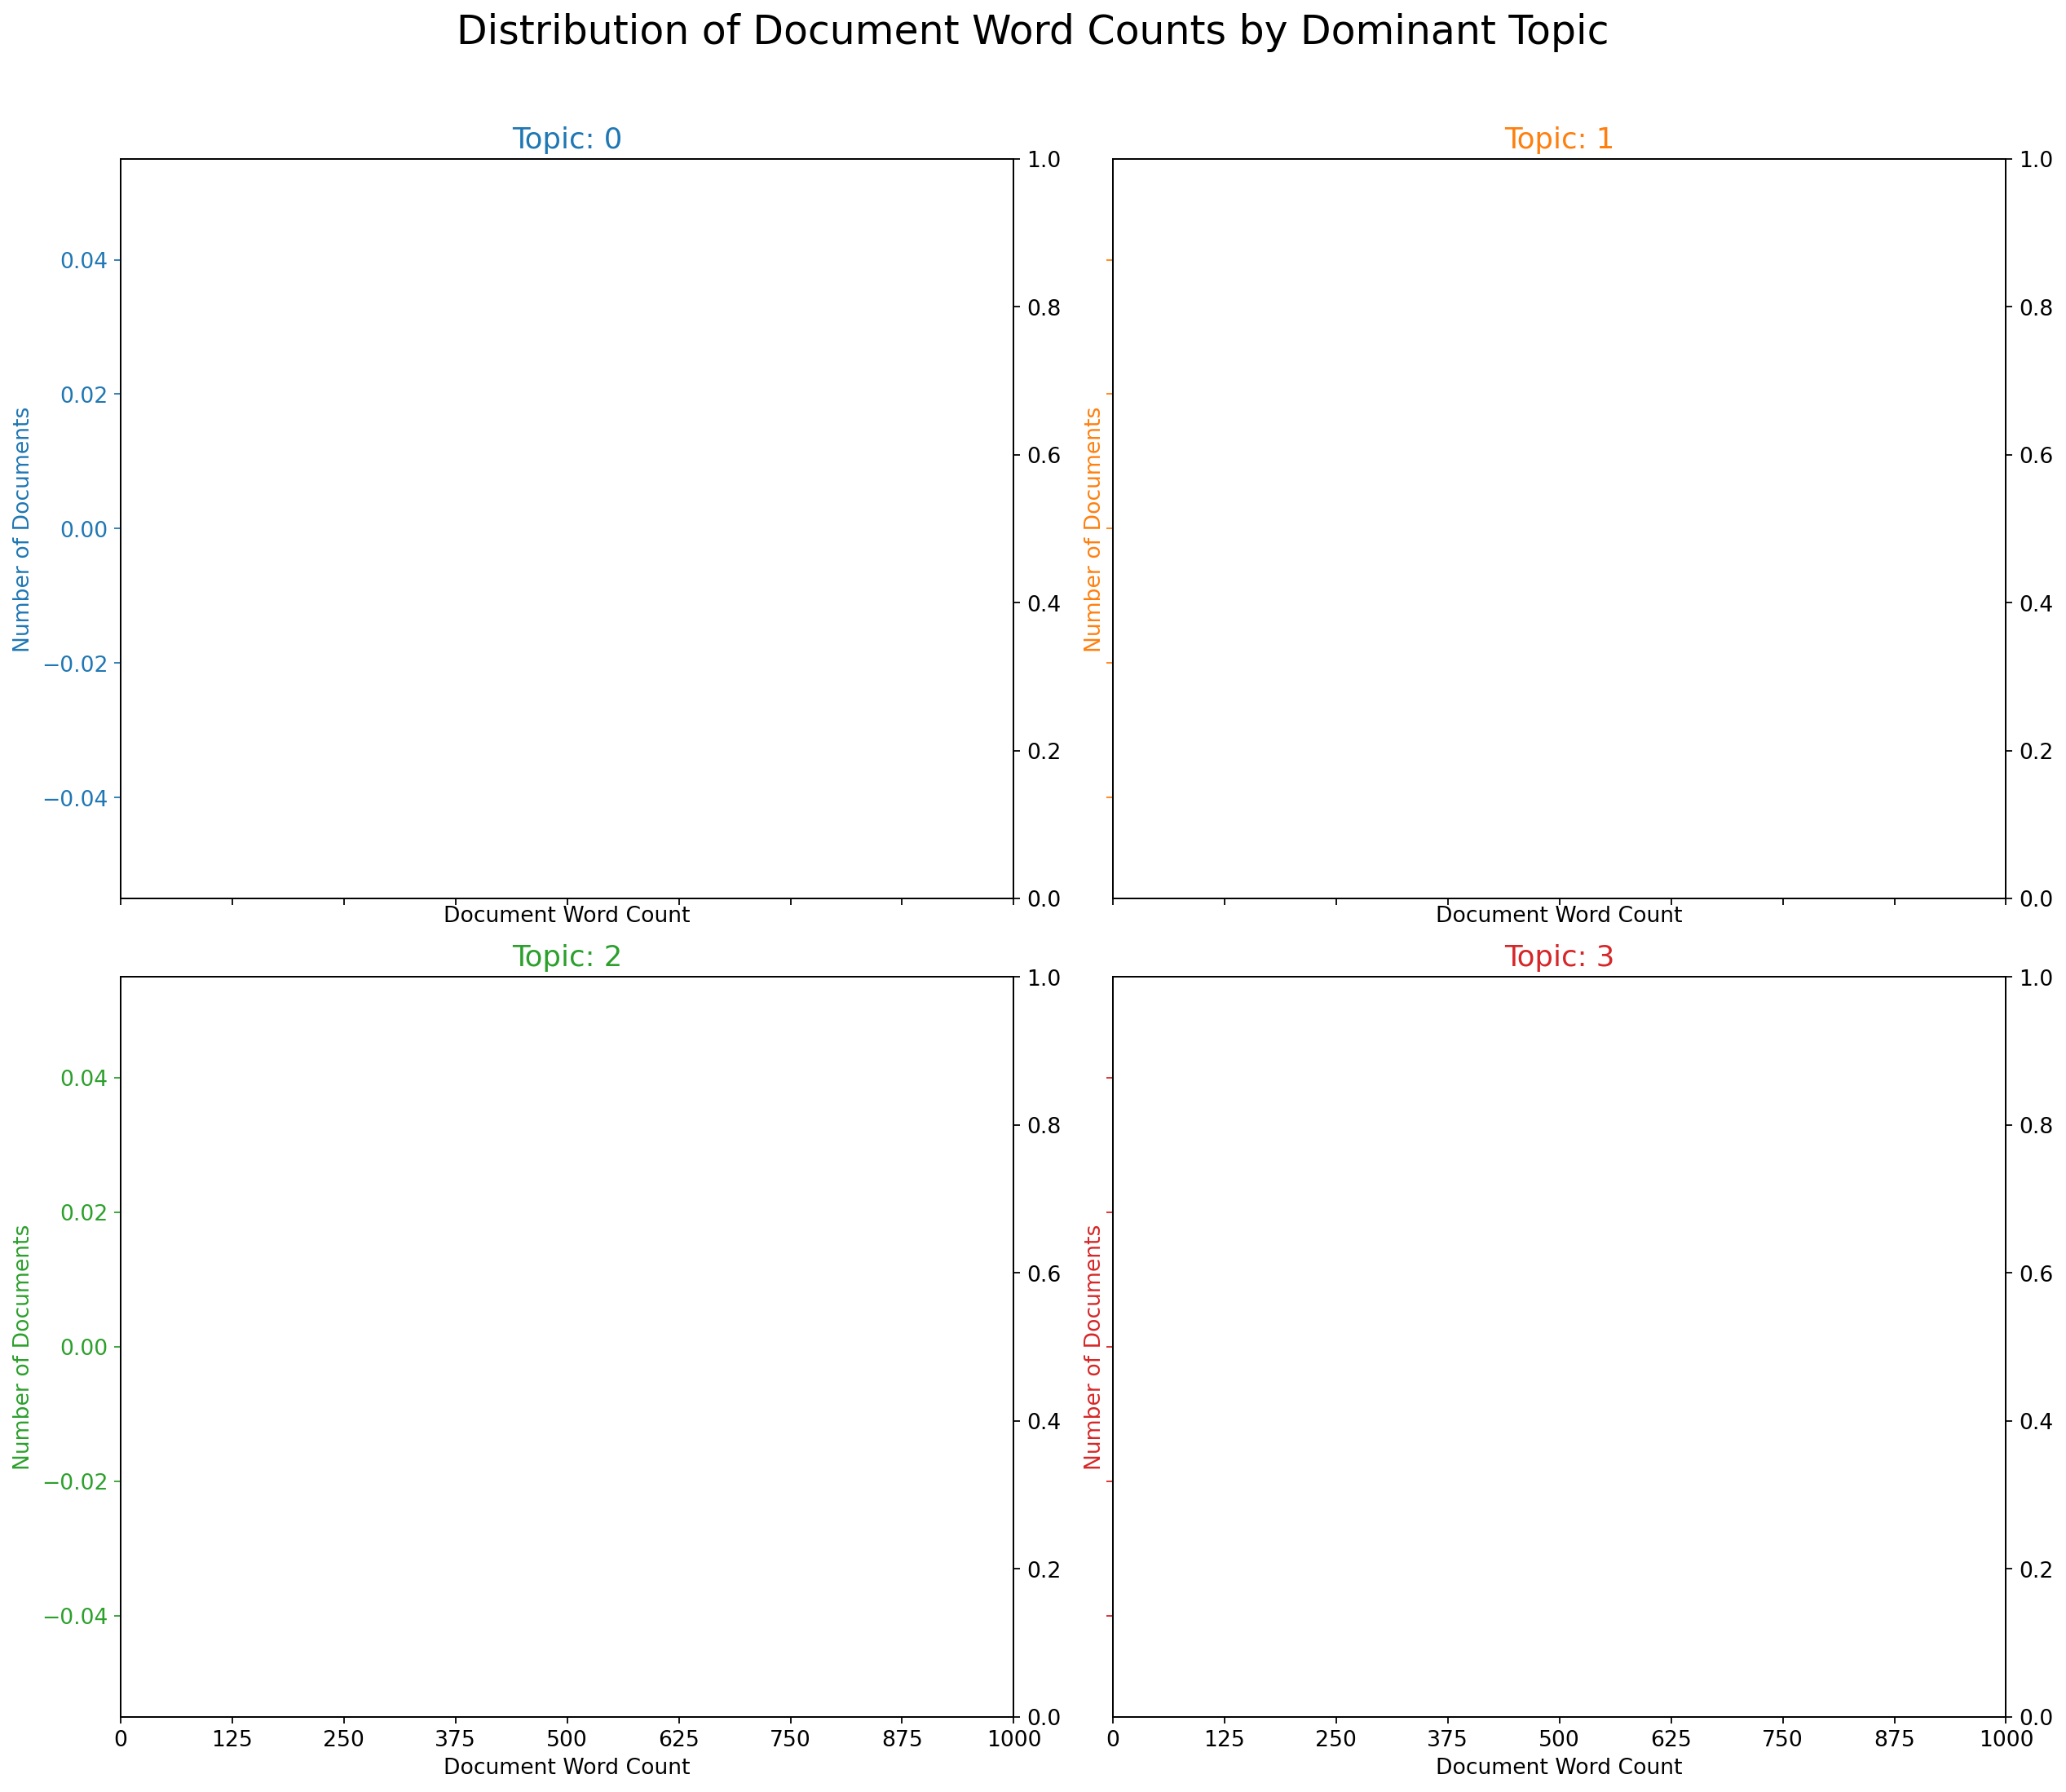

In [92]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
   df_dominant_topic_sub = df.loc[df.content == i, :]
   doc_lens = [len(d) for d in df_dominant_topic_sub.content]
   ax.hist(doc_lens, bins = 1000, color=cols[i])
   ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
   sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
   ax.set(xlim=(0, 1000), xlabel='Document Word Count')
   ax.set_ylabel('Number of Documents', color=cols[i])
   ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

## K-means

In [100]:
from sklearn.cluster import KMeans

documents = df 

X = tfidf.fit_transform(df.content)

In [101]:
true_k = 8
model = KMeans(n_clusters=true_k, init='k-means++',random_state=100, max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 علي
 الي
 العمل
 التعليم
 الوزاره
 مدير
 الدكتور
 العام
 الملكه
 الهيئه
Cluster 1:
 علي
 الي
 حتي
 ايران
 عام
 الملكه
 العالم
 العام
 احد
 حاله
Cluster 2:
 اله
 عسير
 علي
 الامن
 الطوارئ
 الوطن
 قوات
 رجال
 مسجد
 الي
Cluster 3:
 النفط
 المائه
 الي
 اسعار
 مليار
 بنسبه
 علي
 الاسهم
 اسهم
 السوق
Cluster 4:
 ولي
 عبدالعزيز
 الحرمين
 الشريفين
 الامير
 السمو
 الملكي
 خادم
 سلمان
 الملك
Cluster 5:
 البلديه
 المدني
 الانتخابيه
 علي
 الي
 الانتخابات
 الدفاع
 فرق
 لانتخابات
 بمنطقه
Cluster 6:
 الفريق
 علي
 النادي
 الاتحاد
 الاعب
 القدم
 الاعبين
 الموسم
 الي
 المدرب
Cluster 7:
 داعش
 علي
 عدن
 الي
 المقاومه
 تنظيم
 الحوثين
 اليمن
 التحالف
 القوات


In [103]:
model.inertia_

2814.5293527680915

In [104]:
model.cluster_centers_

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.79630952e-05, 1.98257539e-04, 3.83995809e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.29311301e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.82434162e-04, 1.82434162e-04, 1.82434162e-04]])

Cluster 1 Inertia 2876.9336418734656
Cluster 2 Inertia 2864.190718494512
Cluster 3 Inertia 2852.159959958204
Cluster 4 Inertia 2843.1479015006794
Cluster 5 Inertia 2831.717962736234
Cluster 6 Inertia 2825.421983515858
Cluster 7 Inertia 2820.913282578227
Cluster 8 Inertia 2812.7156122200568
Cluster 9 Inertia 2806.25643324469
Cluster 10 Inertia 2802.56120915715
Cluster 11 Inertia 2794.631524727075
Cluster 12 Inertia 2792.017612929118
Cluster 13 Inertia 2788.2144329396106
Cluster 14 Inertia 2785.5437888621236
Cluster 15 Inertia 2778.778526358502
Cluster 16 Inertia 2776.272679711648
Cluster 17 Inertia 2771.667737074132
Cluster 18 Inertia 2768.476664762303
Cluster 19 Inertia 2765.442293100215


Text(0, 0.5, 'WCSS')

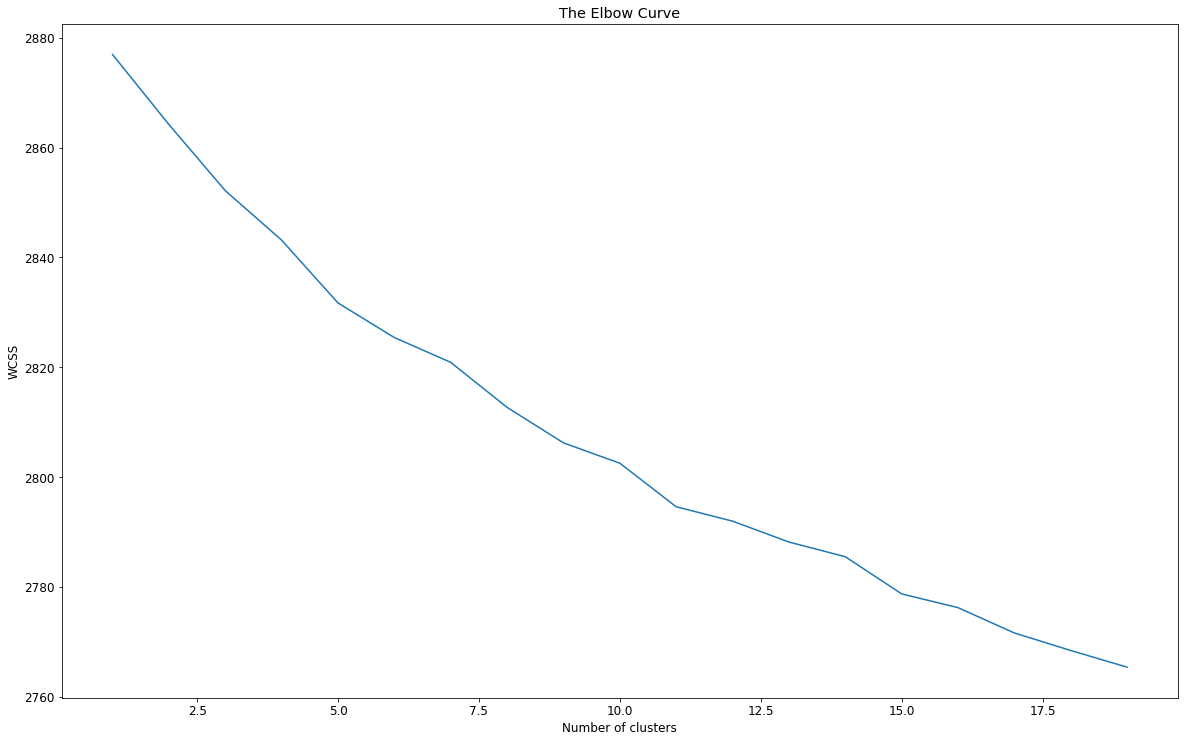

In [105]:
wcss = []
for i in range(1,20):

  kmeans = KMeans(n_clusters=i,init='k-means++' ,max_iter=300,n_init=10,random_state=100)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)
  print('Cluster', i, 'Inertia', kmeans.inertia_)
plt.plot(range(1,20),wcss)
plt.title('The Elbow Curve')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') ##WCSS stands for total within-cluster sum of square

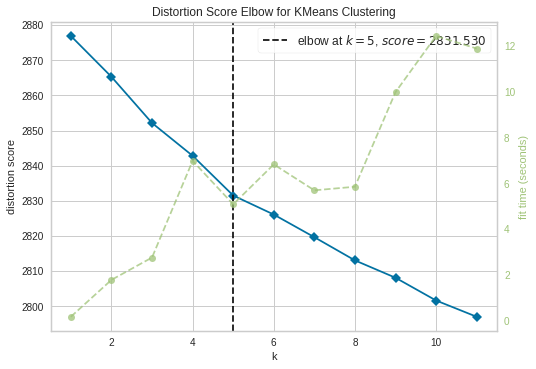

In [106]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12)).fit(X)
visualizer.show();
# k = 5 

In [107]:
g= sns.scatterplot(data=df, x="content", y="content", hue=kmeans.labels_ )

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f50a59cb5f0> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f50a59d30e0> (for post_execute):


KeyboardInterrupt: ignored

## Hierarchical Clustering

In [ ]:
from time import time
from sklearn.cluster import AgglomerativeClustering
X=X.todense()

for linkage in ('ward', 'average', 'complete'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=3)
    t0 = time()
    clustering.fit(X)
    print("%s : %.2fs" % (linkage, time() - t0))
    x,y = zip(*X)
    plt.figure(dpi=200)
    plt.scatter(x,y,c=plt.cm.rainbow(clustering.labels_*20),s=14)
    plt.title("Linkage Type: %s" % linkage)